In [1]:
from skimage import measure
from skimage.transform import resize
from skimage.filters import threshold_otsu, threshold_local, threshold_isodata
from skimage.color import rgb2gray
import os
import re
import gc
import glob
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
## true or false
debug = 0

In [3]:
plot_direc = 'plot'
data_direc = 'us'
shape = (720, 1280) ## better to change
nimg = 10 if debug else 222

# image

In [4]:
def read_data():
    allimage = glob.glob(data_direc + '/*.jpg')
    image = np.empty(nimg, dtype=object)
    label = np.empty((nimg, 6), dtype=object)
    for i, image_name in enumerate(allimage):
        label_name = image_name.rsplit('.')[0] + ".txt"
        img = plt.imread(image_name)
        img = rgb2gray(img)
        image[i] = img
        with open(label_name, 'r') as f:
            txt = f.read()
        lab = txt.strip('\n').split('\t')
        label[i,:] = lab
        
        if i == nimg-1: break
    ## change type
    tmp = label[:,1:5].astype('float')
    label[:,1:5] = tmp
    
    return image, label

## reshape image to same size
def reshape_data(image, label):
    """
    Input:
        image: (nimg,) object array
        label: (nimg, 6) object array
        -- columns: image_name, width_y, height_x, width, height, number
    Output:
        image_reshape: (nimage, shape[0], shape[1]) array
        label_reshape: (nimage, 8) array
        -- columns: image_name, orig_shape0, orig_shape1, height_x, width_y, height, width, number
    """
    image_reshape = np.empty((image.shape[0], shape[0], shape[1]))
    ## new label (image_name, orig_shape0, orig_shape1, new_bb0, new_bb1, new_bb2, new_bb3, number)
    label_reshape = np.empty((label.shape[0], 8), dtype=object)
    for i in range(image.shape[0]):
        img = image[i]
        lab = label[i,:]
        image_reshape[i,:,:] = resize(img, output_shape=shape, mode='reflect',  anti_aliasing=True)
        label_reshape[i,0] = lab[0]
        label_reshape[i,1:3] = img.shape
        x_scale = shape[0] / img.shape[0]
        y_scale = shape[1] / img.shape[1]
        ## height_x, width_y, height, width 
        label_reshape[i,3:7] = [lab[2]*x_scale,lab[1]*y_scale,lab[4]*x_scale,lab[3]*y_scale]
        label_reshape[i,-1] = lab[-1]
    
#     ## change to length ratio
#     label_reshape[:,3] = label_reshape[:,3] / shape[0]
#     label_reshape[:,4] = label_reshape[:,4] / shape[1]
#     label_reshape[:,5] = label_reshape[:,5] / shape[0]
#     label_reshape[:,6] = label_reshape[:,6] / shape[1]
    
    return image_reshape, label_reshape

def gray_2_binary(image):
    bin_image = np.empty(image.shape)
    for i, img in enumerate(image):
        thresh_val = threshold_otsu(img)
        bin_image[i,:,:] = img > thresh_val
    return bin_image

def draw_bb(img, lab):
    print(img.shape)
    bb = lab[-5:-1]
    fig, ax = plt.subplots()
    ax.imshow(img)
    ## (width_y, height_x, width, height)
    rect = patches.Rectangle((bb[1],bb[0]), bb[3], bb[2],linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

In [6]:
def testing_dataset(image, label):
    ## get all bounding box information
    all_bb = label[:,-5:-1]

    ## check the size of the license plate relative to the image
    x = all_bb[:,2]
    y = all_bb[:,3]
    
    print(np.percentile(x, 90) )
    print(np.percentile(y, 90) )

In [7]:
image, label = read_data()

In [15]:
tmp = label[:,-1]
x = set()
for i in range(tmp.shape[0]):
    a = set(tmp[i])
    x = x.union(a)
x

{'0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z'}

In [7]:
image_reshape, label_reshape = reshape_data(image, label)

(720, 1280)


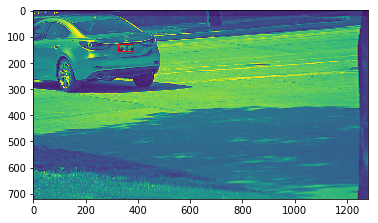

In [12]:
i = np.random.randint(nimg)
# i = 84
draw_bb(image_reshape[i], label_reshape[i])

In [23]:
# ## center and normalize images
# img_mean = image_reshape.mean(axis=1).mean(axis=1)
# img_scale

(222,)

In [9]:
del image, label

# model

In [13]:
## keras
import keras.backend as K
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

import tensorflow as tf

Using TensorFlow backend.


In [14]:
def get_model():
    model = Sequential()
    model.add(Conv2D(filters = 4, kernel_size = (10,10), activation = 'relu', input_shape=(shape[0],shape[1],1)))
#     model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters = 8, kernel_size = (5,5), activation = 'relu'))
    model.add(Conv2D(filters = 16, kernel_size = (5,5), activation = 'relu'))
#     model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(4))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [15]:
model = get_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [16]:
early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, restore_best_weights=True)

model.fit(x=image_reshape[:,:,:,np.newaxis], y=label_reshape[:,-5:-1],
          batch_size=1, epochs=40, verbose=1,
          callbacks=[early_stopper])

Instructions for updating:
Use tf.cast instead.
Epoch 1/40
222/222 [==============================] - 49s 219ms/step - loss: 29096.4294
Epoch 2/40
  1/222 [..............................] - ETA: 32s - loss: 14647.6279

/home/simon/.local/lib/python3.7/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


222/222 [==============================] - 33s 149ms/step - loss: 21261.7617
Epoch 3/40
222/222 [==============================] - 33s 150ms/step - loss: 20441.7563
Epoch 4/40
222/222 [==============================] - 33s 149ms/step - loss: 21706.0945
Epoch 5/40
222/222 [==============================] - 34s 154ms/step - loss: 18776.7261
Epoch 6/40
222/222 [==============================] - 34s 151ms/step - loss: 15638.3986
Epoch 7/40
222/222 [==============================] - 34s 152ms/step - loss: 16461.8793
Epoch 8/40
222/222 [==============================] - 33s 150ms/step - loss: 14080.8004
Epoch 9/40
222/222 [==============================] - 33s 150ms/step - loss: 9046.2624
Epoch 10/40
222/222 [==============================] - 34s 155ms/step - loss: 6606.4763
Epoch 11/40
222/222 [==============================] - 34s 153ms/step - loss: 5549.8514
Epoch 12/40
222/222 [==============================] - 34s 152ms/step - loss: 3646.3120
Epoch 13/40
222/222 [=======================

In [96]:
K.clear_session()

# testing

In [52]:
def check_predict(test_image):
    predict = model.predict(test_image)
    for i in range(predict.shape[0]):
        fig, ax = plt.subplots(figsize=(10,10))
        img = test_image[i]
        ax.imshow(img.reshape(shape))
        bb = predict[i]
        height_x, width_y, height, width = (bb[0], bb[1], bb[2], bb[3])
#         height_x *= shape[0]
#         width_y *= shape[1]
#         height *= shape[0]
#         width *= shape[1]
        ## (width_y, height_x, width, height)
        rect = patches.Rectangle((width_y,height_x), width, height,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        plt.axis('off')
        plt.savefig('test_%d_predict.jpg' % i, bbox_inches='tight')
        ## draw the ground truth
        j = image_idx[i]
        draw_bb(img.reshape(shape), label_reshape[j,:])
        plt.axis('off')
        plt.savefig('test_%d_gt.jpg' % i, bbox_inches='tight')
        print(label_reshape[j,0])

In [53]:
n_test_img = 3
image_idx = np.random.choice(np.arange(nimg), replace=False, size=n_test_img)
test_image = image_reshape[image_idx]
test_image = test_image.reshape((n_test_img, shape[0], shape[1], 1))
name = label_reshape[image_idx, 0]

In [54]:
test_image[0].shape

(720, 1280, 1)

(720, 1280)
37170dd1-2802-4e38-b982-c5d07c64ff67.jpg
(720, 1280)
wts-lg-000074.jpg
(720, 1280)
wts-lg-000155.jpg


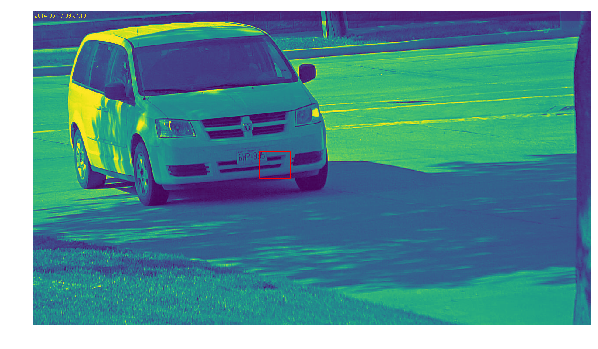

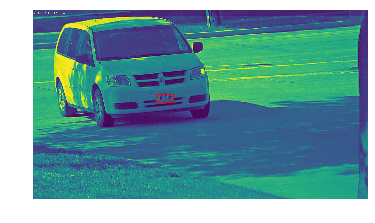

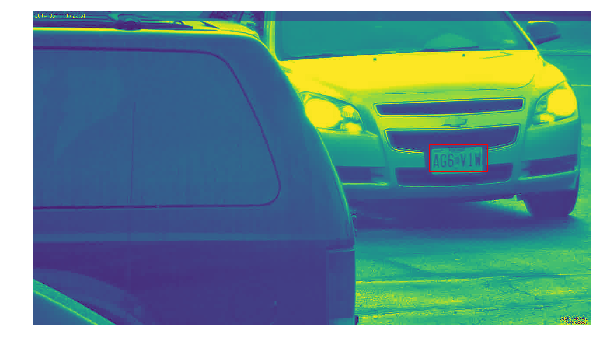

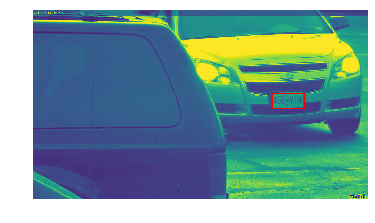

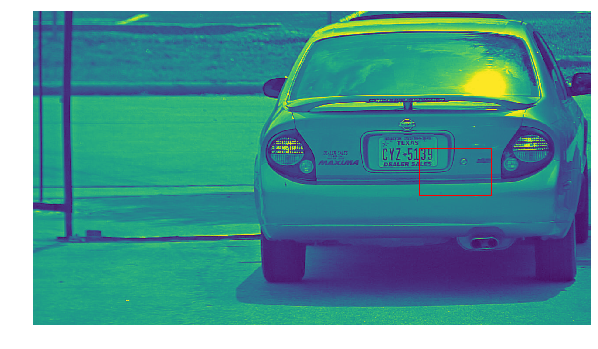

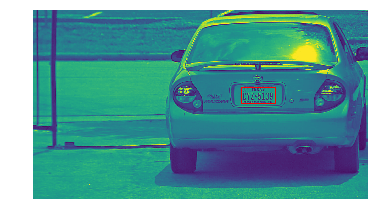

In [55]:
check_predict(test_image)